In [2]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import skew, kurtosis
import pandas as pd

# Entrenamiento de red neuronal convolucional sin hacer uso de las estadísticas de las distribuciones de los histogramas

In [3]:
with open('datos/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('datos/test.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('datos/val.pkl', 'rb') as f:
    val_data = pickle.load(f)


In [4]:
# Crear un mapeo de etiquetas consecutivas
unique_classes = sorted(train_data['Coarse Class ID'].unique())
class_mapping = {original: idx for idx, original in enumerate(unique_classes)}

# Aplicar el mapeo a los datasets
train_data['Coarse Class ID'] = train_data['Coarse Class ID'].map(class_mapping)
test_data['Coarse Class ID'] = test_data['Coarse Class ID'].map(class_mapping)
val_data['Coarse Class ID'] = val_data['Coarse Class ID'].map(class_mapping)

In [5]:
# Función para redimensionar las imágenes al mismo tamaño
def resize_images(image_list, target_size=(128, 128)):
    resized_images = []
    for img in image_list:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return np.array(resized_images)

In [6]:
# Función para balancear clases con ImageDataGenerator
def balance_with_datagen(train_data, target_size=(256, 256), batch_size=32):
    # Determinar el máximo número de imágenes entre todas las clases
    class_counts = train_data['Coarse Class ID'].value_counts()
    max_count = class_counts.max()
    
    # DataFrame para almacenar datos aumentados
    balanced_images = []
    balanced_labels = []
    
    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for class_id, group in train_data.groupby('Coarse Class ID'):
        # Redimensionar imágenes de la clase actual
        images = resize_images(group['image_array'].values, target_size)
        labels = group['Coarse Class ID'].values
        
        # Normalizar imágenes
        images = images / 255.0
        
        # Crear generador para esta clase
        generator = datagen.flow(
            images, 
            labels, 
            batch_size=batch_size
        )
        
        # Generar imágenes hasta alcanzar el máximo número de la clase más grande
        class_images = []
        class_labels = []
        while len(class_images) < max_count:
            batch_images, batch_labels = next(generator)
            class_images.extend(batch_images)
            class_labels.extend(batch_labels)
        
        # Agregar imágenes y etiquetas balanceadas de esta clase
        balanced_images.extend(class_images[:max_count])
        balanced_labels.extend(class_labels[:max_count])
    
    # Convertir a arrays finales
    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)
    return balanced_images, balanced_labels

In [7]:
# Balancear los datos de entrenamiento
target_size = (256, 256)
batch_size = 32
balanced_train_images, balanced_train_labels = balance_with_datagen(train_data, target_size, batch_size)

# Redimensionar y normalizar el conjunto de prueba
test_images = resize_images(test_data['image_array'].values, target_size) / 255.0
test_labels = test_data['Coarse Class ID'].values

val_images = resize_images(val_data['image_array'].values, target_size) / 255.0
val_labels = val_data['Coarse Class ID'].values

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(set(balanced_train_labels)), activation='softmax')
])

/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_21596/3504108872.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [9]:
# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Entrenar el modelo
history = model.fit(
    balanced_train_images,
    balanced_train_labels,
    validation_data=(test_images, test_labels),
    epochs=30,
    batch_size = 16
)

Epoch 1/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 178s 231ms/step - accuracy: 0.4159 - loss: 2.1182 - val_accuracy: 0.6938 - val_loss: 0.9488
Epoch 2/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - accuracy: 0.8470 - loss: 0.4799 - val_accuracy: 0.7722 - val_loss: 0.7716
Epoch 3/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 142s 190ms/step - accuracy: 0.9073 - loss: 0.2815 - val_accuracy: 0.7702 - val_loss: 0.7947
Epoch 4/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - accuracy: 0.9320 - loss: 0.2005 - val_accuracy: 0.7944 - val_loss: 0.7638
Epoch 5/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 142s 190ms/step - accuracy: 0.9510 - loss: 0.1474 - val_accuracy: 0.7714 - val_loss: 0.8649
Epoch 6/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 146s 195ms/step - accuracy: 0.9524 - loss: 0.1440 - val_accuracy: 0.7787 - val_loss: 0.9338
Epoch 7/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 140s 187ms/step - accuracy: 0.9608 - loss: 0.1201 - val_accuracy: 0.7944 - val_loss: 0.8954
Epoch 8/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - accuracy: 0.9641 -

NameError: name 'history' is not defined

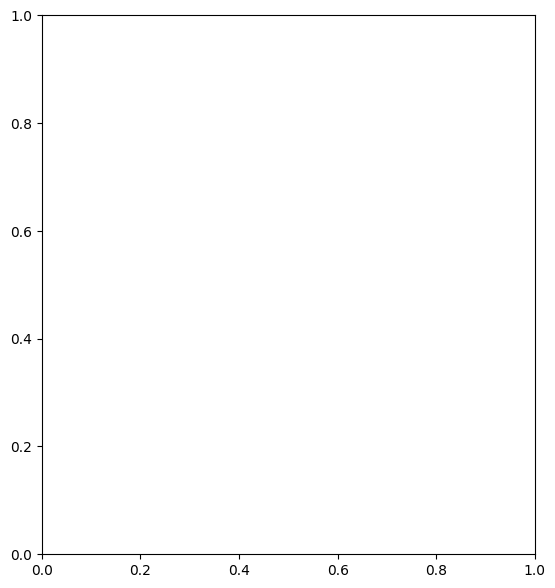

In [10]:
# Graficar las métricas de pérdida y precisión
plt.figure(figsize=(14, 7))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por época')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por época')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(set(balanced_train_labels)), activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model.fit(
    balanced_train_images,
    balanced_train_labels,
    validation_data=(test_images, test_labels),
    epochs=4,
    batch_size = 32
)

/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_21596/634861358.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/4
374/374 ━━━━━━━━━━━━━━━━━━━━ 194s 508ms/step - accuracy: 0.3606 - loss: 2.3429 - val_accuracy: 0.7087 - val_loss: 0.9050
Epoch 2/4
374/374 ━━━━━━━━━━━━━━━━━━━━ 155s 414ms/step - accuracy: 0.8359 - loss: 0.5307 - val_accuracy: 0.7787 - val_loss: 0.7087
Epoch 3/4
374/374 ━━━━━━━━━━━━━━━━━━━━ 155s 414ms/step - accuracy: 0.8987 - loss: 0.3029 - val_accuracy: 0.8012 - val_loss: 0.6646
Epoch 4/4
374/374 ━━━━━━━━━━━━━━━━━━━━ 153s 409ms/step - accuracy: 0.9332 - loss: 0.2124 - val_accuracy: 0.8052 - val_loss: 0.6761


/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_316. Received: the structure of inputs=('*',)
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step
Accuracy: 0.77
Macro Precision: 0.70
Macro Recall: 0.64
Macro F1-Score: 0.64
Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-Score: 0.77

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       1.00      0.60      0.75         5
           4       1.00      0.40      0.57         5
           5       0.00      0.00      0.00         5
           6       0.25      0.67      0.36         3
           7       0.68      0.95      0.79        20
           8       0.00      0.00      0.00         0
           9       0.50      0.40      0.44         5
          10       0.00      0.00      0.00         0
          11       1.00      0.80      0.89         5
          12       1.00      0.60      0.75         5
          13       0.67      0.80   

/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/sklearn/metr

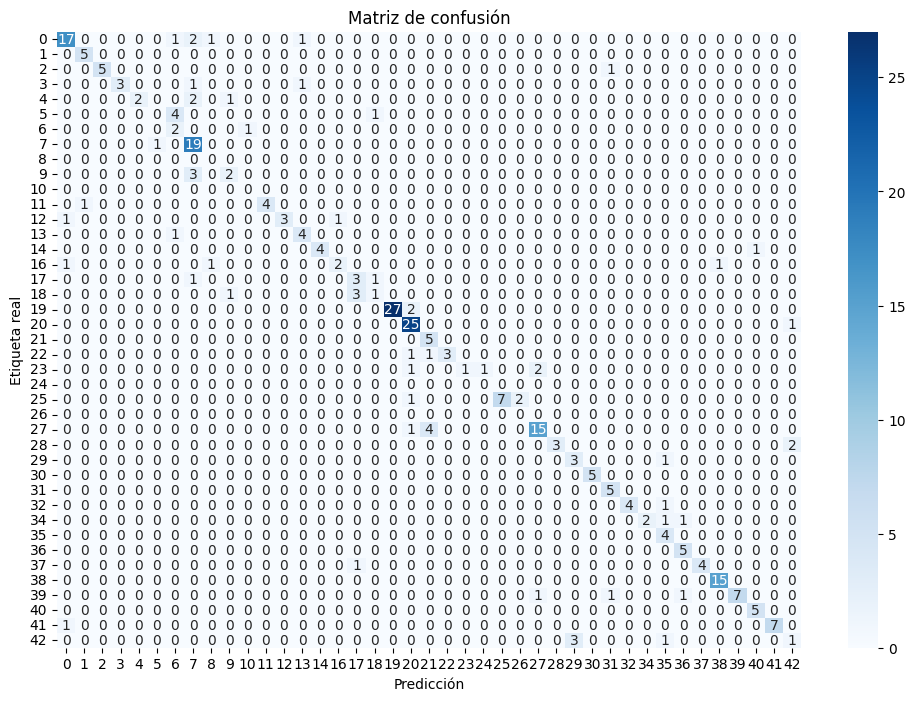

In [12]:
# Realizar predicciones
y_pred = model.predict([val_images])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(val_data['Coarse Class ID'], y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(val_data['Coarse Class ID'], y_pred_classes)
precision_macro = precision_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')
recall_macro = recall_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')
f1_macro = f1_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')

precision_micro = precision_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')
recall_micro = recall_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')
f1_micro = f1_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(val_data['Coarse Class ID']) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    val_data['Coarse Class ID'], 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(val_data['Coarse Class ID'], y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()

# Con estadísticas de imágenes

In [13]:
 # Función para calcular estadísticas detalladas de los canales RGB
def extract_color_statistics(image):
    stats = {}
    for i, color in enumerate(['R', 'G', 'B']):
        channel = image[:, :, i].ravel()
        
        # Estadísticas básicas
        stats[f'{color}_mean'] = np.mean(channel)
        stats[f'{color}_std'] = np.std(channel)
        stats[f'{color}_median'] = np.median(channel)
        stats[f'{color}_25th'] = np.percentile(channel, 25)
        stats[f'{color}_75th'] = np.percentile(channel, 75)
        
        # Estadísticas avanzadas
        stats[f'{color}_skew'] = skew(channel)
        stats[f'{color}_kurtosis'] = kurtosis(channel)
        
        # Adicional: rango y varianza
        stats[f'{color}_range'] = np.max(channel) - np.min(channel)
        stats[f'{color}_variance'] = np.var(channel)
        
    return stats

In [14]:
# Función para procesar todas las imágenes de un conjunto de datos
def process_dataset_statistics(images):
    return [extract_color_statistics(img) for img in images]

In [15]:
# Aplicar la función a tus datasets (train, test, val)
train_detailed_stats = process_dataset_statistics(balanced_train_images)
test_detailed_stats = process_dataset_statistics(test_images)
val_detailed_stats = process_dataset_statistics(val_images)

In [16]:
base_model_2 = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_21596/2814119172.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_2 = tf.keras.applications.MobileNetV2(


In [17]:
train_stats_df = pd.DataFrame(train_detailed_stats)
test_stats_df = pd.DataFrame(test_detailed_stats)
val_stats_df = pd.DataFrame(val_detailed_stats)

In [18]:
# Rama de imágenes basada en el modelo base
image_input = Input(shape=(256, 256, 3), name="image_input")
image_branch = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5)
])(image_input)

stats_input = Input(shape=(train_stats_df.shape[1],), name="stats_input")
stats_branch = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5)
])(stats_input)

In [19]:
combined = concatenate([image_branch, stats_branch])

In [22]:
hidden_layer_3 = Dense(128, activation='relu', name="hidden_layer_1")(combined)  # Nueva capa oculta
hidden_layer_3 = Dropout(0.5, name="dropout_hidden_1")(hidden_layer_3)  # Regularización opcional

hidden_layer_4 = Dense(128, activation='relu', name="hidden_layer_2")(hidden_layer_3)  # Nueva capa oculta
hidden_layer_4 = Dropout(0.5, name="dropout_hidden_2")(hidden_layer_4)  # Regularización opcional


# Capa de salida
output = Dense(len(set(train_data['Coarse Class ID'])), activation='softmax', name="output")(hidden_layer_4)

# Crear el modelo final
model_combined = Model(inputs=[image_input, stats_input], outputs=output)

# Compilar el modelo
model_combined.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
history_combined = model_combined.fit(
    [balanced_train_images, train_stats_df.to_numpy()], balanced_train_labels,
    validation_data=([test_images, test_stats_df.to_numpy()], test_labels),
    epochs=30,
    batch_size=32
)

Epoch 1/30


/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'stats_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 198s 520ms/step - accuracy: 0.0689 - loss: 3.6139 - val_accuracy: 0.3219 - val_loss: 2.2593
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 156s 417ms/step - accuracy: 0.2982 - loss: 2.2467 - val_accuracy: 0.4221 - val_loss: 1.6913
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 157s 418ms/step - accuracy: 0.4428 - loss: 1.6840 - val_accuracy: 0.5706 - val_loss: 1.3757
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 153s 409ms/step - accuracy: 0.5232 - loss: 1.4074 - val_accuracy: 0.5537 - val_loss: 1.2494
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 153s 408ms/step - accuracy: 0.5647 - loss: 1.2537 - val_accuracy: 0.6217 - val_loss: 1.1552
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 155s 415ms/step - accuracy: 0.6111 - loss: 1.1330 - val_accuracy: 0.6483 - val_loss: 1.0650
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 154s 412ms/step - accuracy: 0.6397 - loss: 1.0521 - val_accuracy: 0.6427 - val_loss: 1.0349
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 155s 415ms/step - accuracy: 0.6509 - loss: 1.00

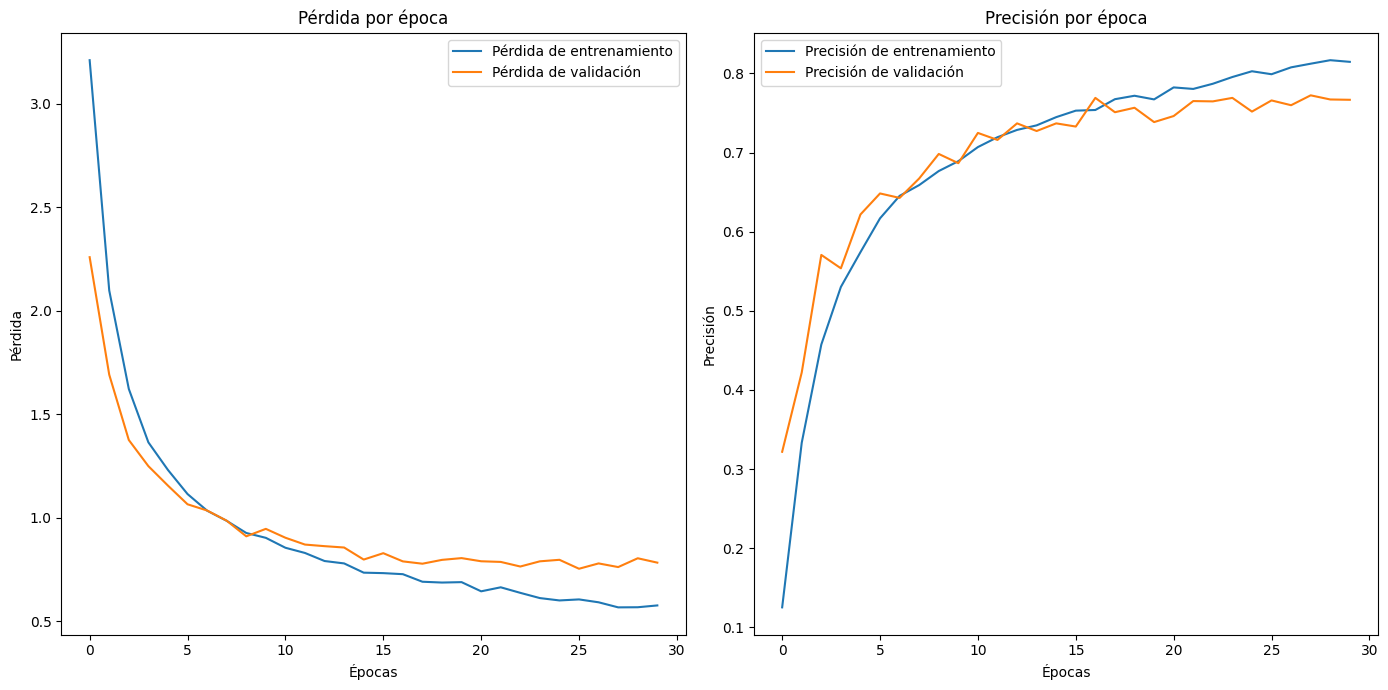

In [24]:
# Graficar las métricas de pérdida y precisión
plt.figure(figsize=(14, 7))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_combined.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por época')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_combined.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por época')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Rama de imágenes basada en el modelo base
image_input = Input(shape=(256, 256, 3), name="image_input")
image_branch = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5)
])(image_input)

stats_input = Input(shape=(train_stats_df.shape[1],), name="stats_input")
stats_branch = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5)
])(stats_input)

combined = concatenate([image_branch, stats_branch])

hidden_layer_3 = Dense(128, activation='relu', name="hidden_layer_1")(combined)  # Nueva capa oculta
hidden_layer_3 = Dropout(0.5, name="dropout_hidden_1")(hidden_layer_3)  # Regularización opcional

hidden_layer_4 = Dense(128, activation='relu', name="hidden_layer_2")(hidden_layer_3)  # Nueva capa oculta
hidden_layer_4 = Dropout(0.5, name="dropout_hidden_2")(hidden_layer_4)  # Regularización opcional


# Capa de salida
output = Dense(len(set(train_data['Coarse Class ID'])), activation='softmax', name="output")(hidden_layer_4)

# Crear el modelo final
model_combined = Model(inputs=[image_input, stats_input], outputs=output)

# Compilar el modelo
model_combined.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_combined = model_combined.fit(
    [balanced_train_images, train_stats_df.to_numpy()], balanced_train_labels,
    validation_data=([test_images, test_stats_df.to_numpy()], test_labels),
    epochs=10,
    batch_size=32
)

Epoch 1/10


/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'stats_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 211s 552ms/step - accuracy: 0.0662 - loss: 3.6534 - val_accuracy: 0.3203 - val_loss: 2.1124
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 173s 461ms/step - accuracy: 0.2786 - loss: 2.3321 - val_accuracy: 0.4740 - val_loss: 1.5936
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 175s 466ms/step - accuracy: 0.4175 - loss: 1.7659 - val_accuracy: 0.4982 - val_loss: 1.3586
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 173s 462ms/step - accuracy: 0.4988 - loss: 1.4724 - val_accuracy: 0.5779 - val_loss: 1.2160
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 177s 473ms/step - accuracy: 0.5517 - loss: 1.2856 - val_accuracy: 0.5883 - val_loss: 1.1336
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 167s 447ms/step - accuracy: 0.5957 - loss: 1.1813 - val_accuracy: 0.6173 - val_loss: 1.0815
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 168s 448ms/step - accuracy: 0.6211 - loss: 1.0827 - val_accuracy: 0.6165 - val_loss: 1.0052
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 175s 467ms/step - accuracy: 0.6504 - loss: 1.00

/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'stats_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step
Accuracy: 0.69
Macro Precision: 0.62
Macro Recall: 0.59
Macro F1-Score: 0.58
Micro Precision: 0.69
Micro Recall: 0.69
Micro F1-Score: 0.69

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.71      1.00      0.83         5
           4       0.67      0.40      0.50         5
           5       1.00      0.80      0.89         5
           6       0.50      1.00      0.67         3
           7       0.94      0.80      0.86        20
           8       0.00      0.00      0.00         0
           9       0.50      0.20      0.29         5
          11       1.00      0.80      0.89         5
          12       0.75      0.60      0.67         5
          13       0.33      0.40      0.36         5
          14       0.60      0.60   

/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/taller2/grocery_store/grocery_store/lib/python3.11/site-packages/skle

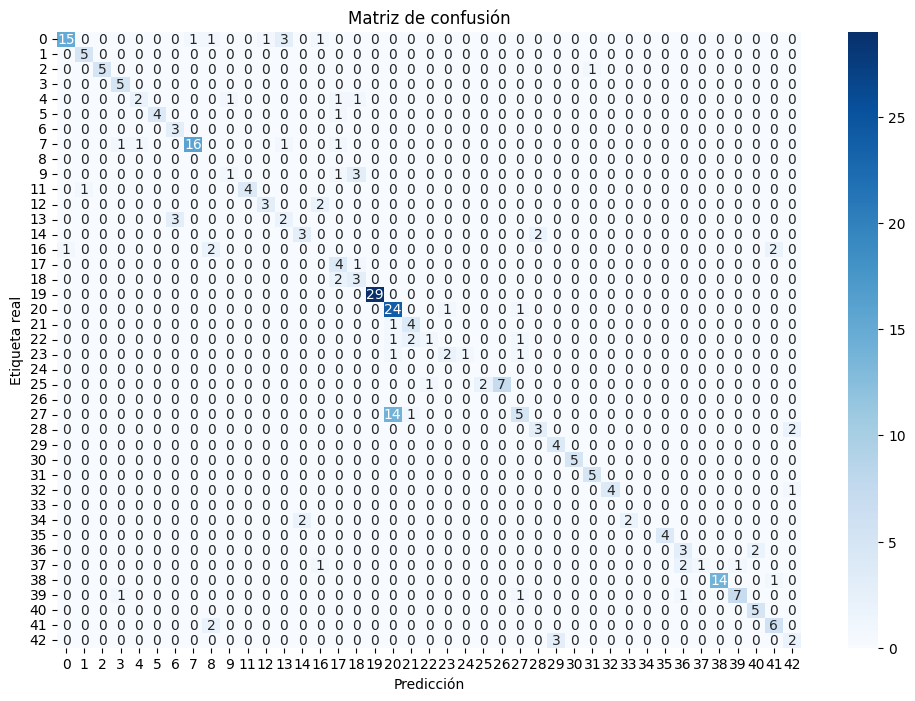

In [27]:
# Realizar predicciones
y_pred = model_combined.predict([val_images, val_stats_df])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(val_data['Coarse Class ID'], y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(val_data['Coarse Class ID'], y_pred_classes)
precision_macro = precision_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')
recall_macro = recall_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')
f1_macro = f1_score(val_data['Coarse Class ID'], y_pred_classes, average='macro')

precision_micro = precision_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')
recall_micro = recall_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')
f1_micro = f1_score(val_data['Coarse Class ID'], y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(val_data['Coarse Class ID']) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    val_data['Coarse Class ID'], 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(val_data['Coarse Class ID'], y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()